# Aprendizaje Automático

## Tarea 4

Profesor: MSc. Felipe Meza.

Instituto Tecnológico de Costa Rica, 

Medio de entrega: TecDigital.

Entregables: El entregable consiste en el url de la notebook Tarea-4.ipynb en GITHUB. 

Grupo de trabajo:
- Manuel Calderón
- Ernesto Rivera

---
Objetivo: El objetivo de la Tarea 4 consiste en utilizar el dataset de la Tarea 3 y aplicarle una red neuronal.

# Manejo y preprocesado de datos


Para el ejemplo de los algoritmos supervisados se escogió el dataset de Agora.csv, utilizado en la tarea 2, ya que proporciona bastantes datos a trabajar.

En las siguientes tres celdas:
- Se importan las bibliotecas necesarias para este documento
- Se lee el archivo **Agora.csv** y se eliminan errores de tabulado usando sustituciones textuales. El resultado final se guarda en el archivo **Agora2.csv**.
- Se carga **Agora2.csv** en un dataframe de pandas.
- Se eliminan los outliers y se convierten los features _Price_ y _Rating_ datos de texto a numéricos, y se eliminan los features que no interesan.
- Se procesa el feature de _Category_ y se transforma usando _one hot encoding_.
- Toma el _Rating_ y se crean categorías o clases.
- Definir valores de entrada y target.

### Importar bibliotecas

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping

from matplotlib import pyplot as plt

import seaborn as sns
%matplotlib inline

### Creacion de metodos auxiliares

In [2]:
def get_grop_df(data_set, mode=1):
    data = {}
    for index, row in data_set.iterrows():
        name = row['Producto/Nombre'] + str(row['Creado en']) + row['Categoría de producto/Nombre completo']
        cantidad = row['Cantidad'] * mode
        if not name in data:
            month = '0' + str(row['Creado en'].month)
            data.update({name:{'Creado en': str(row['Creado en'].year) + month[-2:], 
                               'Producto/Nombre': row['Producto/Nombre'], 
                               'Cantidad': cantidad, 
                               'Categoría de producto/Nombre completo': row['Categoría de producto/Nombre completo']}})
        else:
            data[name].update({'Cantidad': cantidad + data[name]['Cantidad']})
        
    list_data = []
    for ind in data:
        list_data.append(data[ind])

    new_df = pd.DataFrame(list_data)
    return new_df

In [3]:
def convert2matrix(dataset, look_back=1):
    X, Y =[], []
    for i in range(len(dataset)-look_back):
        d=i+look_back  
        X.append(dataset[i:d,0])
        Y.append(dataset[d,0])
    return np.array(X), np.array(Y)

In [4]:
def neural_model(look_back, trainX, trainY, epochs, batch_size):
    model = Sequential()
    model.add(Dense(32, input_dim=look_back, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(testX,testY), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],shuffle=False)
    return model, history


In [5]:
def history_model_plot(dataset, look_back, trainPredict, testPredict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+look_back:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    print(dataset.shape)
    print(trainPredict.shape)
    print(testPredict.shape)
    plt.plot(dataset)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [6]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [7]:
def prediction_plot(testY, test_predict, l):
    len_prediction=[x for x in range(len(testY))]
    plt.figure(figsize=(8,4))
    plt.plot(len_prediction, testY[:l], marker='.', label="actual")
    plt.plot(len_prediction, test_predict[:l], 'r', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Ads Daily Spend', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();


### 1. Leer archivo original y eliminar errores de tabulación
El resultado final es otro archico sin los errores de tabulación.

### 2. Cargar la nueva data

In [8]:
df = pd.read_csv('data_con_masc.csv')
df.head(10)

,Producto/Nombre,Cantidad,Cantidad restante,Creado en,Categoría de producto/Nombre completo,Categoría de producto/Nombre mostrado,Movimiento stock/Ubicación origen/Nombre ubicación,Movimiento stock/Ubicación origen/Nombre mostrado,Movimiento stock/Ubicación destino/Nombre ubicación,Movimiento stock/Ubicación destino/Nombre mostrado
0,Producto base 1,-1.840000e+03,0.0,2021-09-13 23:21:00,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación
1,Producto base 1,-1.840000e+03,0.0,2021-09-13 23:21:00,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación
2,Producto base 1,3.680000e+03,0.0,2021-09-13 23:20:51,Categoría 1,Categoría 1,Fabricación,Ubicaciones virtuales/Fabricación,Stock,fis_2/Stock
3,Producto base 1,1.270020e-13,0.0,2021-09-12 14:21:48,Categoría 1,Categoría 1,NaN,NaN,NaN,NaN
4,Producto base 1,-7.530000e+02,0.0,2021-09-11 16:54:07,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación
5,Producto base 1,3.300000e+01,0.0,2021-09-11 16:54:01,Categoría 1,Categoría 1,Fabricación,Ubicaciones virtuales/Fabricación,Stock,fis_2/Stock
6,Producto base 1,7.200000e+02,0.0,2021-09-11 16:54:01,Categoría 1,Categoría 1,Fabricación,Ubicaciones virtuales/Fabricación,Stock,fis_2/Stock
7,Producto base 1,-1.400000e-02,0.0,2021-09-10 22:39:49,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación
8,Producto base 1,-1.857986e+03,0.0,2021-09-10 22:39:49,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación
9,Producto base 1,-1.840000e+03,0.0,2021-09-10 22:39:49,Categoría 1,Categoría 1,Stock,fis_2/Stock,Fabricación,Ubicaciones virtuales/Fabricación


In [9]:
df.describe()

,Cantidad,Cantidad restante
count,15817.000000,15817.000000
mean,9.343426,9.343426
std,12551.471255,826.509531
min,-383000.000000,0.000000
25%,-160.000000,0.000000
50%,-5.000000,0.000000
75%,1.000000,0.000000
max,836270.000000,100102.828000


In [10]:
df.columns

Index(['Producto/Nombre', 'Cantidad', 'Cantidad restante', 'Creado en',
       'Categoría de producto/Nombre completo',
       'Categoría de producto/Nombre mostrado',
       'Movimiento stock/Ubicación origen/Nombre ubicación',
       'Movimiento stock/Ubicación origen/Nombre mostrado',
       'Movimiento stock/Ubicación destino/Nombre ubicación',
       'Movimiento stock/Ubicación destino/Nombre mostrado'],
      dtype='object')

### 3. Limpiar datos y manejar tipos de datos
Consiste en eliminar outliers y remover caracteres de columnas para poder convertirlas en números.

In [11]:
# Se eliminan columnas innecesarias Cantidad restante,Categoría de producto/Nombre mostrado, 
# Movimiento stock/Ubicación origen/Nombre ubicación, Movimiento stock/Ubicación destino/Nombre ubicación

df.drop(columns=["Cantidad restante", "Categoría de producto/Nombre mostrado", 
                 "Movimiento stock/Ubicación origen/Nombre ubicación",
                 "Movimiento stock/Ubicación origen/Nombre mostrado",
                 "Movimiento stock/Ubicación destino/Nombre mostrado",
                 "Movimiento stock/Ubicación destino/Nombre ubicación"], inplace=True)
print('Columnas restantes:', df.columns)

# Redondeo de columnas a 4 decimales e eliminiacion de los 0
df = df.round({"Cantidad": 4})
df=df[df["Cantidad"] != 0]

df.describe()

Columnas restantes: Index(['Producto/Nombre', 'Cantidad', 'Creado en',
       'Categoría de producto/Nombre completo'],
      dtype='object')


,Cantidad
count,14683.000000
mean,10.065039
std,13027.177926
min,-383000.000000
25%,-234.600000
50%,-7.000000
75%,15.000000
max,836270.000000


### Entradas de inventario

In [12]:
# Se separan el dataset en 2 tipos de dataset para el analisis, positivos como estradas 
# y negativos como salida estas a su vez se convertirán a positivo en su respectivo analisis

df_in_pr = df[df["Cantidad"] > 0] 
df_in_pr['Creado en'] = pd.to_datetime(df_in_pr['Creado en']).dt.to_period('m')
df_in_pr.head(10)

<ipython-input-12-e356a7bd3392>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_pr['Creado en'] = pd.to_datetime(df_in_pr['Creado en']).dt.to_period('m')


,Producto/Nombre,Cantidad,Creado en,Categoría de producto/Nombre completo
2,Producto base 1,3680.0,2021-09,Categoría 1
5,Producto base 1,33.0,2021-09,Categoría 1
6,Producto base 1,720.0,2021-09,Categoría 1
10,Producto base 1,18.0,2021-09,Categoría 1
11,Producto base 1,3680.0,2021-09,Categoría 1
14,Producto base 1,80.0,2021-09,Categoría 1
15,Producto base 1,4200.0,2021-09,Categoría 1
17,Producto base 1,1400.0,2021-09,Categoría 1
21,Producto base 1,144.0,2021-09,Categoría 1
22,Producto base 1,9200.0,2021-09,Categoría 1


In [13]:
new_df_in_pr = get_grop_df(df_in_pr)

new_df_in_pr.head(10)

,Creado en,Producto/Nombre,Cantidad,Categoría de producto/Nombre completo
0,202109,Producto base 1,54861.000,Categoría 1
1,202108,Producto base 1,140732.000,Categoría 1
2,202107,Producto base 1,145354.000,Categoría 1
3,202106,Producto base 1,147469.000,Categoría 1
4,202105,Producto base 1,135650.275,Categoría 1
5,202104,Producto base 1,166707.000,Categoría 1
6,202103,Producto base 1,153820.000,Categoría 1
7,202102,Producto base 1,115075.000,Categoría 1
8,202101,Producto base 1,129823.000,Categoría 1
9,202012,Producto base 1,150542.000,Categoría 1


In [14]:
new_df_in_pr.describe()

,Cantidad
count,338.000000
mean,38096.511638
std,83581.174511
min,2.000000
25%,833.750000
50%,6690.956550
75%,48060.000000
max,836270.000000


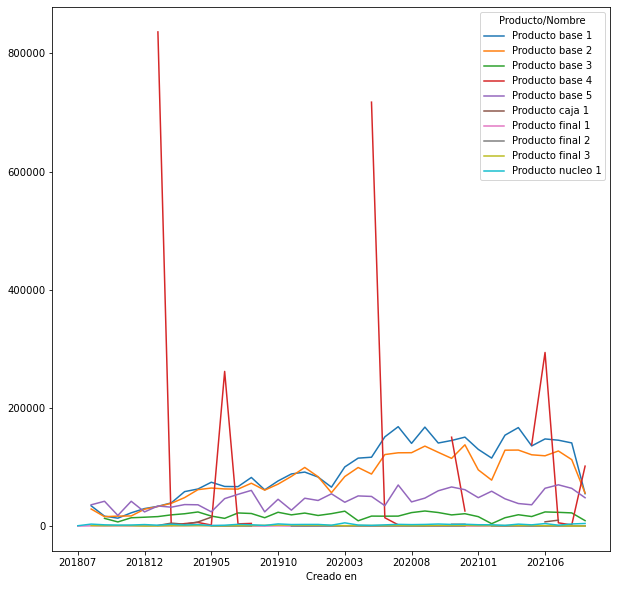

In [15]:
new_df_in_pr.pivot(index="Creado en", columns="Producto/Nombre", values="Cantidad").plot(figsize=(10,10))
plt.show()

In [16]:
new_df_in_pr = new_df_in_pr[new_df_in_pr["Producto/Nombre"] == 'Producto base 1'] 
new_df_in_pr.drop(columns=["Creado en","Producto/Nombre", 'Categoría de producto/Nombre completo'], inplace=True)

new_df_in_pr['Cantidad'] = MinMaxScaler().fit_transform(np.array(new_df_in_pr['Cantidad']).reshape(-1,1))

new_df_in_pr.describe()

dataset = new_df_in_pr.values

In [17]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 1
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

model, history = neural_model(trainX.shape[1], trainX, trainY, 300, 20)



In [18]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

Train Score: 0.05 MSE (0.18 MAE)
Test Score: 0.05 MSE (0.18 MAE)


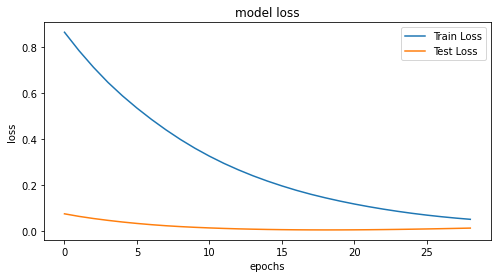

In [19]:
model_loss(history)

In [20]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

(38, 1)
(24, 1)
(12, 1)


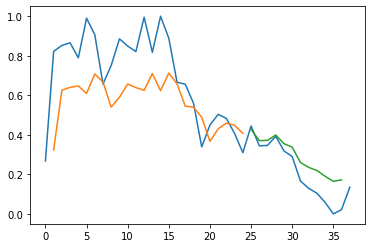

In [21]:
history_model_plot(dataset, look_back, trainPredict, testPredict)

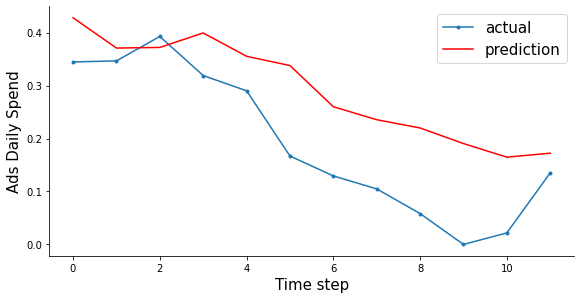

In [22]:
prediction_plot(testY, testPredict, testY.shape[0])

### Salidas de inventario

In [23]:
df_out_pr = df[df["Cantidad"] < 0] 
df_out_pr['Creado en'] = pd.to_datetime(df_out_pr['Creado en']).dt.to_period('m')
print(df_out_pr)

       Producto/Nombre  Cantidad Creado en  \
0      Producto base 1 -1840.000   2021-09   
1      Producto base 1 -1840.000   2021-09   
4      Producto base 1  -753.000   2021-09   
7      Producto base 1    -0.014   2021-09   
8      Producto base 1 -1857.986   2021-09   
...                ...       ...       ...   
15795  Producto base 5    -0.010   2018-09   
15796  Producto base 5 -6005.100   2018-09   
15797  Producto base 5 -1000.000   2018-09   
15798  Producto base 5 -6020.510   2018-09   
15799  Producto base 5 -6000.000   2018-09   

      Categoría de producto/Nombre completo  
0                               Categoría 1  
1                               Categoría 1  
4                               Categoría 1  
7                               Categoría 1  
8                               Categoría 1  
...                                     ...  
15795                           Categoria 7  
15796                           Categoria 7  
15797                           C

<ipython-input-23-6ee233a33a3b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out_pr['Creado en'] = pd.to_datetime(df_out_pr['Creado en']).dt.to_period('m')


In [24]:
df_out_pr.describe()

,Cantidad
count,10564.000000
mean,-1204.925782
std,6646.053849
min,-383000.000000
25%,-1840.000000
50%,-73.600000
75%,-5.000000
max,-0.000200


In [25]:
new_df_out_pr = get_grop_df(df_out_pr, -1)

new_df_out_pr.head(10)

,Creado en,Producto/Nombre,Cantidad,Categoría de producto/Nombre completo
0,202109,Producto base 1,54861.000,Categoría 1
1,202108,Producto base 1,140732.000,Categoría 1
2,202107,Producto base 1,145354.000,Categoría 1
3,202106,Producto base 1,147469.000,Categoría 1
4,202105,Producto base 1,135650.275,Categoría 1
5,202104,Producto base 1,166707.000,Categoría 1
6,202103,Producto base 1,153820.000,Categoría 1
7,202102,Producto base 1,115075.000,Categoría 1
8,202101,Producto base 1,129823.000,Categoría 1
9,202012,Producto base 1,150542.000,Categoría 1


In [26]:
new_df_out_pr.describe()

,Cantidad
count,359.000000
mean,35456.367589
std,58221.310276
min,11.000000
25%,852.000000
50%,4270.000000
75%,54018.217200
max,431827.636000


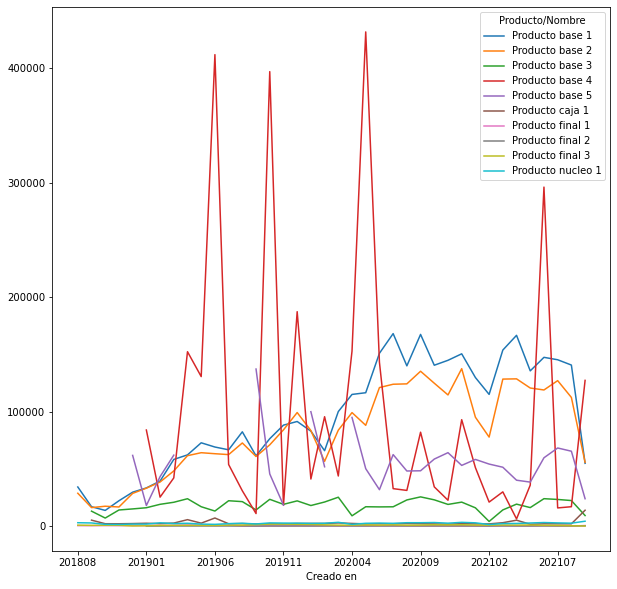

In [27]:
new_df_out_pr.pivot(index="Creado en", columns="Producto/Nombre", values="Cantidad").plot(figsize=(10,10))
plt.show()

In [28]:
new_df_out_pr = new_df_out_pr[new_df_out_pr["Producto/Nombre"] == 'Producto base 1'] 
new_df_out_pr.drop(columns=["Creado en","Producto/Nombre", 'Categoría de producto/Nombre completo'], inplace=True)

new_df_out_pr['Cantidad'] = MinMaxScaler().fit_transform(np.array(new_df_out_pr['Cantidad']).reshape(-1,1))

new_df_out_pr.describe()

dataset = new_df_out_pr.values

In [29]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape dataset
look_back = 1
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

model, history = neural_model(trainX.shape[1], trainX, trainY, 300, 20)

In [30]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (trainScore[0], trainScore[1]))


Train Score: 0.06 MSE (0.21 MAE)
Test Score: 0.06 MSE (0.21 MAE)


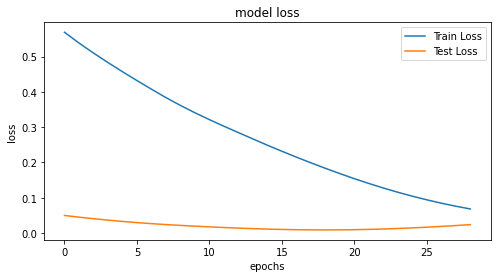

In [31]:
model_loss(history)

In [32]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

(38, 1)
(24, 1)
(12, 1)


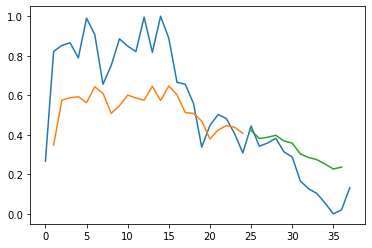

In [33]:
history_model_plot(dataset, look_back, trainPredict, testPredict)


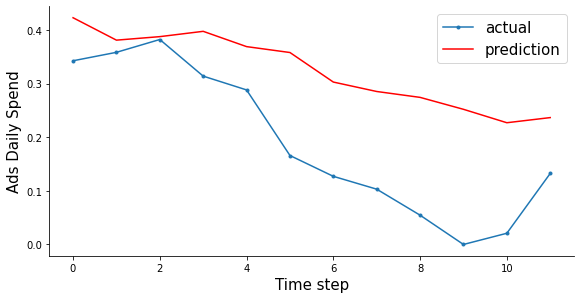

In [34]:

prediction_plot(testY, testPredict, testY.shape[0])